In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from tqdm import tqdm

from flash_ansr import SkeletonPool, get_path, Tokenizer
from flash_ansr.eval.metrics.bootstrap import bootstrapped_metric_ci

In [2]:
from sympy import simplify, parse_expr
from simplipy import SimpliPyEngine
from simplipy.utils import explicit_constant_placeholders, numbers_to_constant

In [3]:
MODEL = 'v23.0-3M'
ENGINE = 'dev_7-3'

In [4]:
pool = SkeletonPool.from_config(get_path('configs', MODEL, 'skeleton_pool_train.yaml'))
pool.simplify = False
pool.sample_strategy['max_tries'] = 1000

tokenizer = Tokenizer.from_config(get_path('configs', MODEL, 'tokenizer.yaml'))

engine = SimpliPyEngine.load('dev_7-3')

Compiling Skeletons: 100%|██████████| 107/107 [00:00<00:00, 16382.80it/s]


In [5]:
import multiprocessing as mp

def _simplify_worker(queue, expr_str, ratio):
    expr = parse_expr(expr_str)
    if ratio is not None:
        start_time = time.time()
        result = simplify(expr, ratio=ratio)
        end_time = time.time()
    else:
        start_time = time.time()
        result = simplify(expr)
        end_time = time.time()
    queue.put((result, end_time - start_time))

def run_simplify_with_timeout(expr_str, ratio=None, timeout_seconds=1):
    # Run sympy.simplify in a subprocess so we can kill long-running work cleanly in notebooks.
    queue = mp.Queue()
    proc = mp.Process(target=_simplify_worker, args=(queue, expr_str, ratio))
    proc.start()
    proc.join(timeout_seconds)
    if proc.is_alive():
        proc.terminate()
        proc.join()
        return None
    if queue.empty():
        return None
    return queue.get()

def sympy_simplify_wrapper(expression: list[str], ratio=None, debug=False):
    # Remove mult and div operators by converting to multiplication to constants. SymPy does not support mult and div operators directly.
    expression = tokenizer.constantify_expression(expression, exact=True)

    assert not any(token.startswith('mult') or token.startswith('div') for token in expression), 'Expression still contains mult/div operators.'

    expression, constants = explicit_constant_placeholders(list(expression))
    if debug: print(expression)

    expression = engine.prefix_to_infix(expression, power='**')
    if debug: print(expression)

    for c in constants:
        expression = expression.replace(c, str(np.random.uniform(-10, 10)))
    if debug: print(expression)

    if debug: print('Simplifying in subprocess...')
    result = run_simplify_with_timeout(expression, ratio=ratio, timeout_seconds=1)
    if result is None:
        return None, None
    expression, elapsed_time = result
    expression = str(expression)
    if debug: print(expression)

    translations = {
        'Abs': 'abs',
    }

    for translate_from, translate_to in translations.items():
        expression = expression.replace(translate_from, translate_to)

    if debug: print(f'Parsing {expression}')
    expression = engine.parse(expression)
    if debug: print(expression)

    expression = numbers_to_constant(expression, inplace=True)
    if debug: print(expression)

    return tuple(expression), elapsed_time

In [6]:
sympy_simplify_wrapper(['+', 'x1', 'x1'], debug=True)

['+', 'x1', 'x1']
x1 + x1
x1 + x1
Simplifying in subprocess...
2*x1
Parsing 2*x1
['*', '2', 'x1']
['*', '<constant>', 'x1']


(('*', '<constant>', 'x1'), 0.053461551666259766)

In [7]:
N_SAMPLES = 2**16
# N_SAMPLES = 2**8
print(f'{N_SAMPLES:,}')

65,536


In [8]:
READ = True

In [9]:
if READ:
    with open(get_path('results', 'simplification', filename='simplification_results_simplipy.pkl'), 'rb') as f:
        simplification_results_simplipy = pickle.load(f)
else:
    simplification_results_simplipy = {}

    for max_pattern_length in range(0, 8):
        simplification_results_simplipy[f'simplipy_{max_pattern_length}'] = []

        pbar = tqdm(total=N_SAMPLES, smoothing=0)
        while len(simplification_results_simplipy[f'simplipy_{max_pattern_length}']) < N_SAMPLES:
            skeleton, _, _ = pool.sample_skeleton()

            pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

            start_time = time.time()
            skeleton_simplified = engine.simplify(skeleton, max_pattern_length=max_pattern_length)
            end_time = time.time()

            simplification_results_simplipy[f'simplipy_{max_pattern_length}'].append({
                'original': skeleton,
                'simplified': skeleton_simplified,
                'time': end_time - start_time,
            })

            pbar.update(1)

        pbar.close()

    with open(get_path('results', 'simplification', filename='simplification_results_simplipy.pkl'), 'wb') as f:
        pickle.dump(simplification_results_simplipy, f)

In [10]:
if READ:
    with open(get_path('results', 'simplification', filename='simplification_results_sympy.pkl'), 'rb') as f:
        simplification_results_sympy = pickle.load(f)
else:
    simplification_results_sympy = {}
    
    for ratio in [None, 1]:
        simplification_results_sympy[f'sympy_{ratio}'] = []

        pbar = tqdm(total=N_SAMPLES, smoothing=0)
        while len(simplification_results_sympy[f'sympy_{ratio}']) < N_SAMPLES:
            skeleton, _, _ = pool.sample_skeleton()

            pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

            sympy_simplified, elapsed_time = sympy_simplify_wrapper(skeleton, ratio=ratio)

            simplification_results_sympy[f'sympy_{ratio}'].append({
                'original': skeleton,
                'simplified': sympy_simplified,
                'time': elapsed_time,
            })

            pbar.update(1)

        pbar.close()

    with open(get_path('results', 'simplification', filename='simplification_results_sympy.pkl'), 'wb') as f:
        pickle.dump(simplification_results_sympy, f)

In [11]:
# merge the two results
results = simplification_results_simplipy | simplification_results_sympy
results.keys()

dict_keys(['simplipy_0', 'simplipy_1', 'simplipy_2', 'simplipy_3', 'simplipy_4', 'simplipy_5', 'simplipy_6', 'simplipy_7', 'sympy_None', 'sympy_1'])

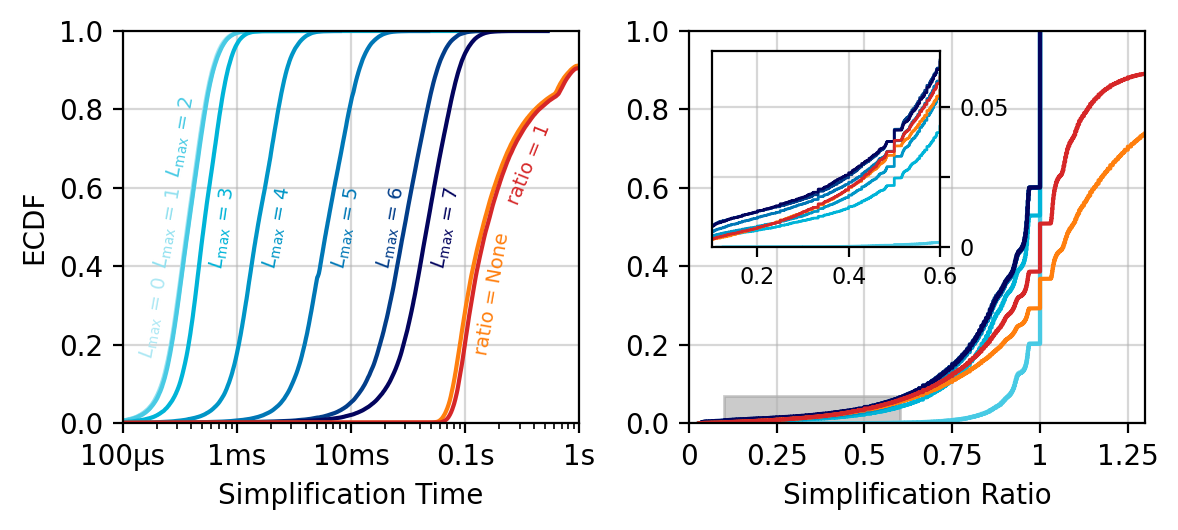

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.75), dpi=200)

plot_every_n = 256

colors_sympy = ['tab:orange', 'tab:red']

all_colors = {
    'simplipy_0': '#ade8f4',
    'simplipy_1': '#90e0ef',
    'simplipy_2': '#48cae4',
    'simplipy_3': '#00b4d8',
    'simplipy_4': '#0096c7',
    'simplipy_5': '#0077b6',
    'simplipy_6': '#023e8a',
    'simplipy_7': '#03045e',
    'sympy_None': colors_sympy[0],
    'sympy_1': colors_sympy[1],
}

legend_labels = {
    'simplipy_0': 'SimpliPy ($L_\\text{max}$=0)',
    'simplipy_1': 'SimpliPy ($L_\\text{max}$=1)',
    'simplipy_2': 'SimpliPy ($L_\\text{max}$=2)',
    'simplipy_3': 'SimpliPy ($L_\\text{max}$=3)',
    'simplipy_4': 'SimpliPy ($L_\\text{max}$=4)',
    'simplipy_5': 'SimpliPy ($L_\\text{max}$=5)',
    'simplipy_6': 'SimpliPy ($L_\\text{max}$=6)',
    'simplipy_7': 'SimpliPy ($L_\\text{max}$=7)',
    'sympy_None': 'SymPy (no ratio)',
    'sympy_1': 'SymPy (ratio=1)',
}

for method, method_results in results.items():
    times = [r['time'] for r in method_results]
    # Replace None with infinity for plotting
    times = [t if t is not None else float('inf') for t in times]

    x = np.sort(times)
    y = np.linspace(0, 1, len(times))

    axes[0].plot(
        x, y,
        label=method,
        color=all_colors[method],
    )

    axes[0].set_xscale('log')
    axes[0].set_xlabel('Simplification Time')
    axes[0].set_ylabel('ECDF')
    # axes[0].legend()
    axes[0].set_xlim(1e-4, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
    axes[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
    axes[0].set_xticklabels(['100µs', '1ms', '10ms', '0.1s', '1s'])
    axes[0].grid(alpha=0.5)

coordinates = [(0.07, 0.27, 80), (0.1, 0.5, 80), (0.13, 0.73, 80), (0.22, 0.5, 82), (0.34, 0.5, 80), (0.49, 0.5, 80), (0.59, 0.5, 80), (0.71, 0.5, 80), (0.81, 0.33, 80), (0.89, 0.66, 68)]

for color, (name, label), coordinates in zip(all_colors.values(), legend_labels.items(), coordinates):
    if "simplipy" in name:
        axes[0].annotate(f'$L_\\text{{max}}$ = {name.split("_")[1]}', xy=coordinates[:2], xycoords='axes fraction', color=color, rotation=coordinates[2], fontsize=7, ha='center', va='center')
    else:
        setting = 'ratio = None' if 'None' in name else 'ratio = 1'
        axes[0].annotate(setting, xy=coordinates[:2], xycoords='axes fraction', color=color, rotation=coordinates[2], fontsize=7, ha='center', va='center')


for method, method_results in results.items():
    original_lengths = [len(r['original']) if r['original'] is not None else float('inf') for r in method_results]
    simplified_lengths = [len(r['simplified']) if r['simplified'] is not None else float('inf') for r in method_results]
    ratios = [
        simplified / original if original > 0 else float('inf')
        for original, simplified in zip(original_lengths, simplified_lengths)
    ]
    x = np.sort(ratios)
    y = np.linspace(0, 1, len(ratios))

    axes[1].plot(
        x, y,
        label=legend_labels[method],
        color=all_colors[method],
    )

    axes[1].set_xlabel('Simplification Ratio')
    # axes[1].set_ylabel('ECDF')
    # axes[1].legend(fontsize=9)
    axes[1].set_xlim(0, 1.3)
    axes[1].set_xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
    axes[1].set_xticklabels([0, 0.25, 0.5, 0.75, 1, 1.25])
    axes[1].set_ylim(0, 1)
    axes[1].grid(alpha=0.5)

axes[1].set_ylim(0, 1)

# Create a zoomed in axis on top of axis[1] showing the range [0, 0.8] x [0, 0.2]
axin = axes[1].inset_axes([0.05, 0.45, 0.5, 0.5])

for method, method_results in results.items():
    original_lengths = [len(r['original']) if r['original'] is not None else float('inf') for r in method_results]
    simplified_lengths = [len(r['simplified']) if r['simplified'] is not None else float('inf') for r in method_results]
    ratios = [
        simplified / original if original > 0 else float('inf')
        for original, simplified in zip(original_lengths, simplified_lengths)
    ]
    x = np.sort(ratios)
    y = np.linspace(0, 1, len(ratios))

    axin.plot(
        x, y,
        label=legend_labels[method],
        color=all_colors[method],
        linewidth=1.0,
    )
axin.grid(alpha=0.5)
axin.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axin.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8], fontsize=8)

axin.set_yticks([0, 0.025, 0.05])
axin.set_yticklabels([0, '', 0.05], fontsize=8)
axin.yaxis.tick_right()

axin.set_xlim(0.1, 0.6)
axin.set_ylim(0, 0.07)

# Highlight the area corresponding to the zoomed in axis by shading in a rectangle
axes[1].add_patch(plt.Rectangle((0.1, 0), 0.5, 0.07, fill=True, color='#999999', alpha=0.5))

fig.tight_layout()

plt.savefig(get_path('results', 'simplification', filename='simplification_comparison_simplipy_sympy.svg'))

In [104]:
median, lower, upper = bootstrapped_metric_ci(np.array([r['time'] is None for r in simplification_results_sympy['sympy_1']]), np.mean)
print(f'SymPy ratio=1 failure rate: {median*100:.2f}% (+{upper*100:.2f}%, -{lower*100:.2f}%)')

SymPy ratio=1 failure rate: 9.57% (+9.80%, -9.34%)


In [105]:
median, lower, upper = bootstrapped_metric_ci(np.array([r['time'] is None for r in simplification_results_sympy['sympy_None']]), np.mean)
print(f'SymPy ratio=None failure rate: {median*100:.2f}% (+{upper*100:.2f}%, -{lower*100:.2f}%)')

SymPy ratio=None failure rate: 8.88% (+9.09%, -8.66%)


In [106]:
for i in range(8):
    median, lower, upper = bootstrapped_metric_ci(np.array([r['time'] is None for r in simplification_results_simplipy[f'simplipy_{i}']]), np.mean)
    print(f'SimpliPy L_max={i} failure rate: {median*100:.2f}% (+{upper*100:.2f}%, -{lower*100:.2f}%)')

SimpliPy L_max=0 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=1 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=2 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=3 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=4 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=5 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=6 failure rate: 0.00% (+0.00%, -0.00%)
SimpliPy L_max=7 failure rate: 0.00% (+0.00%, -0.00%)
